# IMG_4503

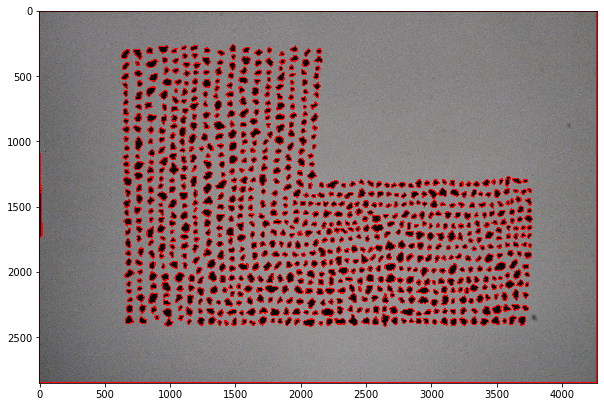

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Tue Mar 17 17:38:06 2020

@author: sayaka71
"""
# scriptの更新を反映するおまじない
%load_ext autoreload
%autoreload 2

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline


# グラフ描画の関数定義
def display(img,cmap=None):
    fig = plt.figure(figsize=(10,8))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap=cmap)

# グレー画像
img = cv2.imread('IMG_4503.jpg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


# 大津法で2値化 retはbool値
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# ノイズを消す
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# 確実な背景
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# --- 距離変換　（オブジェクトと背景の距離を出す） ---
# 閾値（距離変換で得られた値の最大値×0.2） ←ここを調節！
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform, 0.2*dist_transform.max(), 255, 0)

# 距離変換の結果から確実な前景を
sure_fg = np.uint8(sure_fg)

# 前景でも後景でもないUnknown
unknown = cv2.subtract(sure_bg,sure_fg)


# オブジェクトごとにラベルをつける
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers+1
markers[unknown==255] = 0

# markersデータをもとにwatershed
markers = cv2.watershed(img, markers)

# contours(輪郭), hierarchy(階層，親子)
contours, hierarchy = cv2.findContours(markers.copy(),cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

for i in range(len(contours)):
    
    if hierarchy[0][i][3] == -1:
        # 境界を赤色で描く  (255, 0,　0)： color red,  5pt line
        cv2.drawContours(img, contours, i, (255, 0, 0), 5)
        
display(img)

In [2]:
img.shape

(2848, 4272, 3)

In [3]:
# 外れ値をdelete（あとで外れ値がわかるけど先に削除しとく）
contours = np.delete(contours, 1678,0)
contours = np.delete(contours, 1341,0)

In [45]:
# 粒子の形状を測定
from math import sqrt
Areas = []
Perimeters = []
Circularities = []
Eq_diameters = []
Longest = []
Shortest = []
Distance = []

for cnt in contours:
    # 面積 (px*px)
    area = cv2.contourArea(cnt)
    Areas.append(area)
    
    # 周囲長(perimeter)
    arc = cv2.arcLength(cnt, True)
    Perimeters.append(arc)
    # 円形度(circularity)
    circularity = 4 * np.pi * area/(arc*arc)
    Circularities.append(circularity)
    
    # 等価直径(px)
    eq_diameter = np.sqrt(4 * area/np.pi)
    Eq_diameters.append(eq_diameter)
    
    # 重心(Moment)
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # 重心から輪郭までの距離(Distance)
    
    for cnts in cnt:
        # cntの(x,y)座標
        x = cnts[0,0]
        y = cnts[0,1]
        # distance(Moment and cnt)
        dis = sqrt((x-cx)**2 + (y-cy)**2)
        
        # scaleを合わせる
        dis = dis/eq_diameter
        Distance.append(dis)
        
    # Ellipse - shortest, longest ax
    ellipse = cv2.fitEllipse(cnt)
    Shortest.append(ellipse[1][0])
    Longest.append(ellipse[1][1])

In [46]:
cnt_1 = contours[0]
ellipse = cv2.fitEllipse(cnt)
print(ellipse[1][0])
print(ellipse[1][1])

46.55720901489258
56.00411605834961


In [47]:
len(Distance)

109697

Text(0.5, 1.0, 'Distance(~2000)')

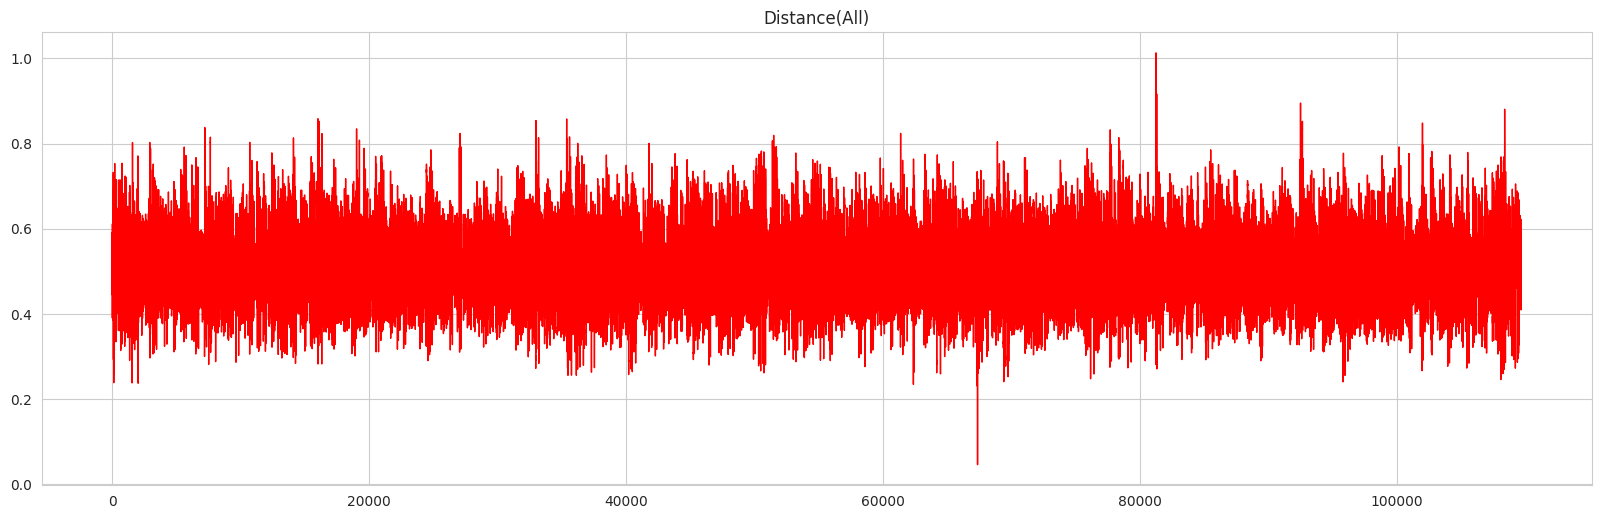

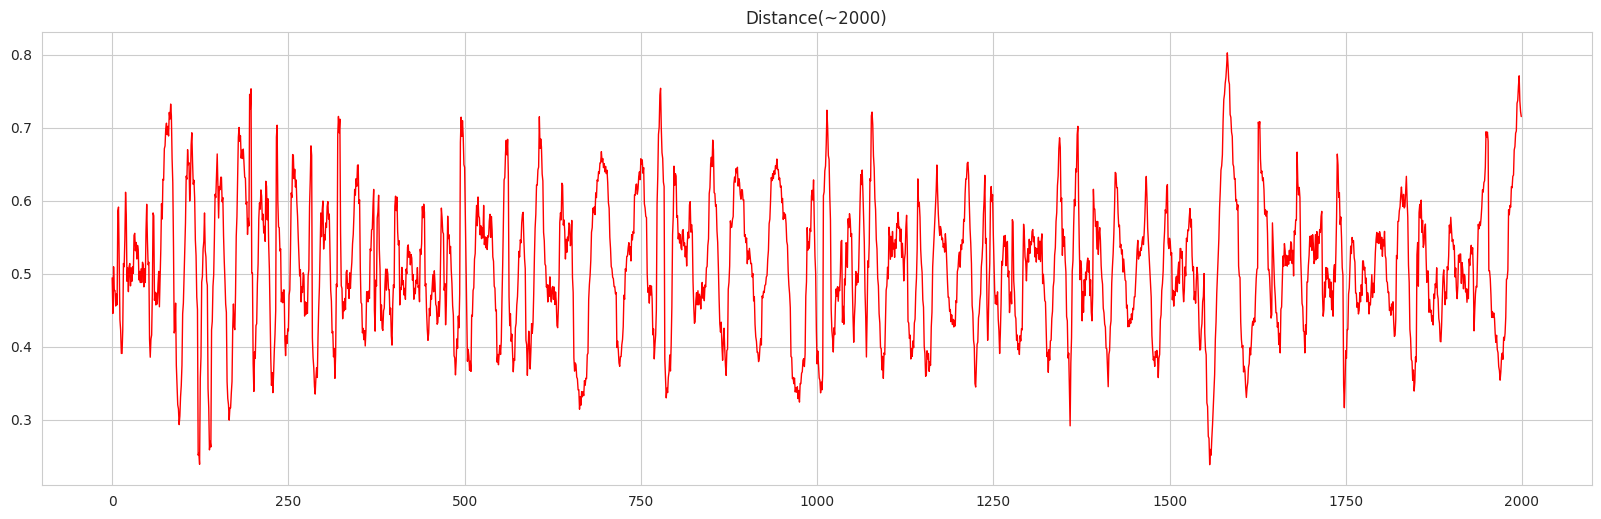

In [48]:
# Distanceをプロット
import seaborn as sns
sns.set_style('whitegrid')
plt.figure(figsize=(20,6), dpi=100)
plt.plot(np.arange(len(Distance)), Distance, c='r', lw=1)
plt.title('Distance(All)')

plt.figure(figsize=(20,6), dpi=100)
plt.plot(np.arange(len(Distance[:2000])), Distance[:2000], c='r', lw=1)
plt.title('Distance(~2000)')

OpenCV公式サイト⇨ [moment](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html)

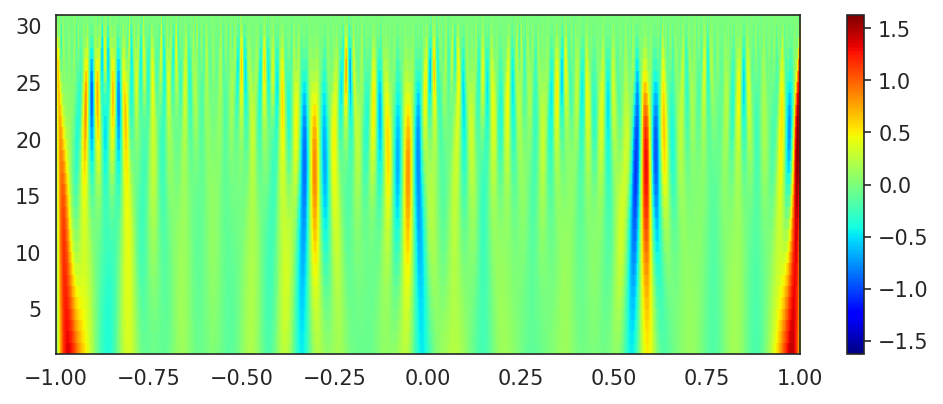

In [49]:
# wavenet
import pywt
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(Distance[:2000], widths, 'mexh')
sns.set_style('white')
plt.figure(figsize=(8, 3), dpi=150)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='jet', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())
plt.colorbar();

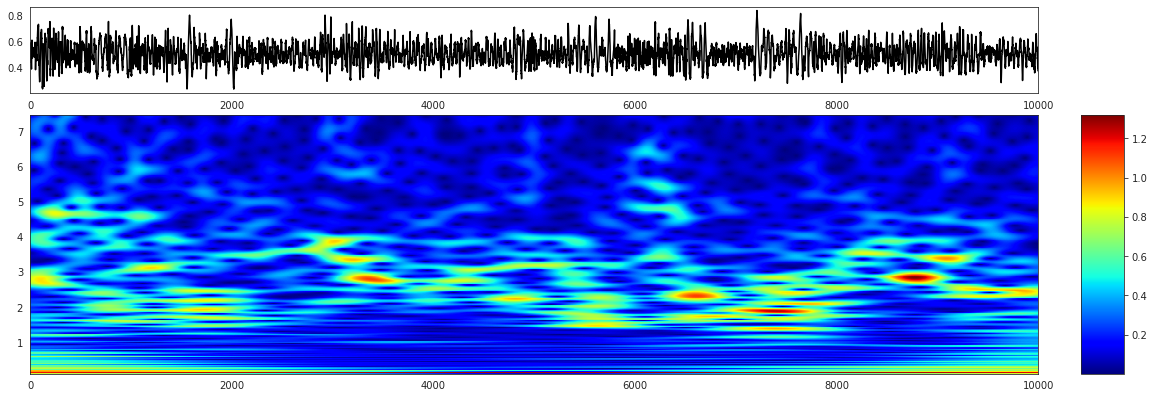

In [24]:
# wavelet swan

from swan import pycwt

Fs = 1/0.01
omega0 = 6
# (1)　Freqを指定してcwt
freqs=np.arange(0.1,7.5,0.025)
r=pycwt.cwt_f(Distance[:10000],freqs,Fs,pycwt.Morlet(omega0))
rr=np.abs(r)

plt.rcParams['figure.figsize'] = (20, 6)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(np.arange(len(Distance[:10000])), Distance[:10000], 'k')

img = ax2.imshow(np.flipud(rr), extent=[0, 10000, freqs[0], freqs[-1]],
                 aspect='auto', interpolation='nearest', cmap='jet')

fig.colorbar(img, cax=ax3)

plt.show()

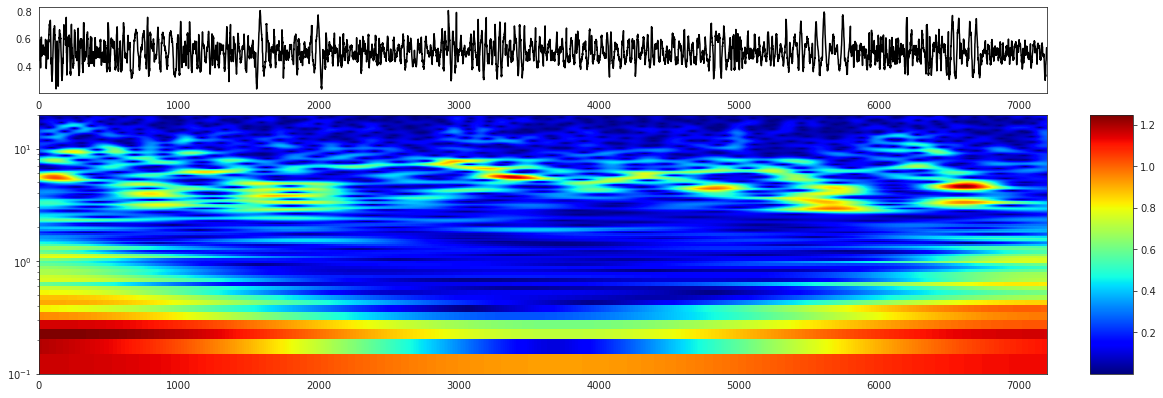

In [41]:
# morlet wavelet n=200 (n=7200/36)

sns.set_style('white')
from swan import pycwt
x = np.arange(len(Distance[:7200]))
y = Distance[:7200]
              
Fs = 1/0.01
# 0.2, 1, 2, 8...
omega0 = 4
# (1)　Freqを指定してcwt
freqs=np.arange(0.1,10,0.025)
r=pycwt.cwt_f(y,freqs,Fs,pycwt.Morlet(omega0))
rr=np.abs(r)


plt.rcParams['figure.figsize'] = (20, 6)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(x, y, 'k')

img = ax2.imshow(np.flipud(rr), extent=[0, 7200,0.1, 20], aspect='auto', cmap='jet') 
twin_ax = ax2
twin_ax.set_yscale('log')
twin_ax.set_xlim(0, 7200)
twin_ax.set_ylim(0.1, 20)
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)
fig.colorbar(img, cax=ax3)
plt.show()

# Distance_Gomez

In [4]:
from math import sqrt, pi ,acos
from tqdm import tqdm
from scipy.spatial import distance

# 粒子の形状を測定
Areas = []
Perimeters = []
Circularities = []
Eq_diameters = []
Longest = []
Shortest = []
Distance_Gomez = []
angles = np.arange(0, 2*pi, 2*pi/36) # angle: 10度ずつで回す (2pi/36 = 10度)

for cnt in tqdm(contours):
    # 面積 (px*px)
    area = cv2.contourArea(cnt)
    Areas.append(area)
    
    # 周囲長(perimeter)
    arc = cv2.arcLength(cnt, True)
    Perimeters.append(arc)
    # 円形度(circularity)
    circularity = 4 * np.pi * area/(arc*arc)
    Circularities.append(circularity)
    
    # 等価直径(px)
    eq_diameter = np.sqrt(4 * area/np.pi)
    Eq_diameters.append(eq_diameter)
    
    # 重心(Moment)
    M = cv2.moments(cnt)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    
    # 重心から輪郭までの距離(Distance_Gomez)
    dis_all = []
    for angle in angles:
        for cnts in cnt:
            # cntの(x,y)座標
            x = cnts[0,0]
            y = cnts[0,1]
            # ユークリッド距離
            d_eu = distance.euclidean((x,y), (cx,cy))
            dis_all.append(d_eu)
            # xを求める(誤差1度まで)
            if abs(acos((x-cx)/d_eu) - angle) < pi/360:
                break
            else:
                continue
        # scaleを合わせる
        d_eu = d_eu/eq_diameter
        Distance_Gomez.append(d_eu)
    # 最長・最短径 -Radius- (shortest, longest) 
    shortest = min(dis_all)
    longest = max(dis_all)
    Shortest.append(shortest)
    Longest.append(longest)
            
        

100%|██████████| 1677/1677 [01:40<00:00, 16.66it/s]


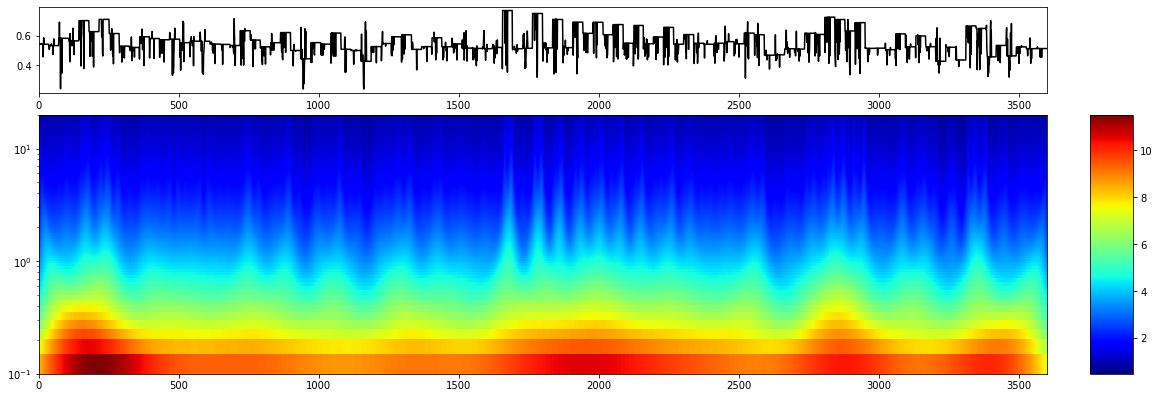

In [43]:
# wavelet swan
from swan import pycwt

x = np.arange(len(Distance_Gomez[:3600]))
y = Distance_Gomez[:3600]
              
Fs = 1/0.01
omega0 = 0.2

# (1)　Freqを指定してcwt
freqs=np.arange(0.1,10,0.025)
r=pycwt.cwt_f(y,freqs,Fs,pycwt.Morlet(omega0))
rr=np.abs(r)


plt.rcParams['figure.figsize'] = (20, 6)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(x, y, 'k')

img = ax2.imshow(np.flipud(rr), extent=[0, 3600,0.1, 20], aspect='auto', cmap='jet') 
twin_ax = ax2
twin_ax.set_yscale('log')
twin_ax.set_xlim(0, 3600)
twin_ax.set_ylim(0.1, 20)
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)
fig.colorbar(img, cax=ax3)
plt.show()

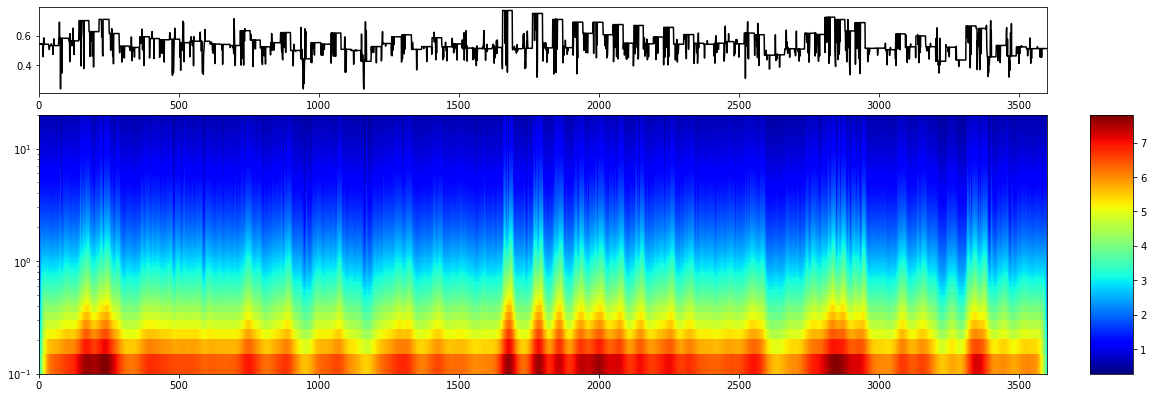

In [42]:
# wavelet swan

from swan import pycwt
x = np.arange(len(Distance_Gomez[:3600]))
y = Distance_Gomez[:3600]
              
Fs = 1/0.01
omega0 = 0.02
# (1)　Freqを指定してcwt
freqs=np.arange(0.1,10,0.025)
r=pycwt.cwt_f(y,freqs,Fs,pycwt.Morlet(omega0))
rr=np.abs(r)


plt.rcParams['figure.figsize'] = (20, 6)
fig = plt.figure()
ax1 = fig.add_axes([0.1, 0.75, 0.7, 0.2])
ax2 = fig.add_axes([0.1, 0.1, 0.7, 0.60], sharex=ax1)
ax3 = fig.add_axes([0.83, 0.1, 0.03, 0.6])

ax1.plot(x, y, 'k')

img = ax2.imshow(np.flipud(rr), extent=[0, 3600,0.1, 20], aspect='auto', cmap='jet') 
twin_ax = ax2
twin_ax.set_yscale('log')
twin_ax.set_xlim(0, 3600)
twin_ax.set_ylim(0.1, 20)
ax2.tick_params(which='both', labelleft=False, left=False)
twin_ax.tick_params(which='both', labelleft=True, left=True, labelright=False)
fig.colorbar(img, cax=ax3)
plt.show()

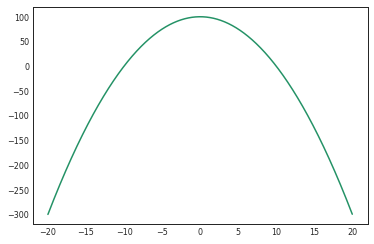

In [133]:
from math import pi, sin, cos, sqrt, acos
from scipy.spatial import distance

def sample_xy(x):
    y = -x**2 +100
    return y
Y = []
X = np.arange(-20, 20, 0.01)

for i in X:
    Y.append(sample_xy(i))
plt.plot(X, Y);

# distance, (0,0)~Y
x0, y0 = 0, 0

# angle: 10度ずつで回す (2pi/36 = 10度)
angles = np.arange(0, 2*pi, 2*pi/36)
num = len(X)
for angle in angles:
    for i in range(num):
        x = X[i]
        y = Y[i]
        # ユークリッド距離
        d = distance.euclidean((x,y), (x0, y0))
        if abs(acos(x/d) - angle) < 0.01:
            break
        else:
            continue
    print(f'{angle*180/pi:.1f}度')
    print(f'x: {x:.2f}, y: {y:.2f}, d: {d:.2f}')
    print('')

36.0


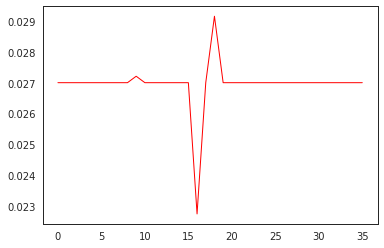

In [198]:
print(len(Distance_Gomez)/len(contours))
plt.plot(np.arange(len(Distance_Gomez[0:36])), Distance_Gomez[0:36], c='r', lw=1)

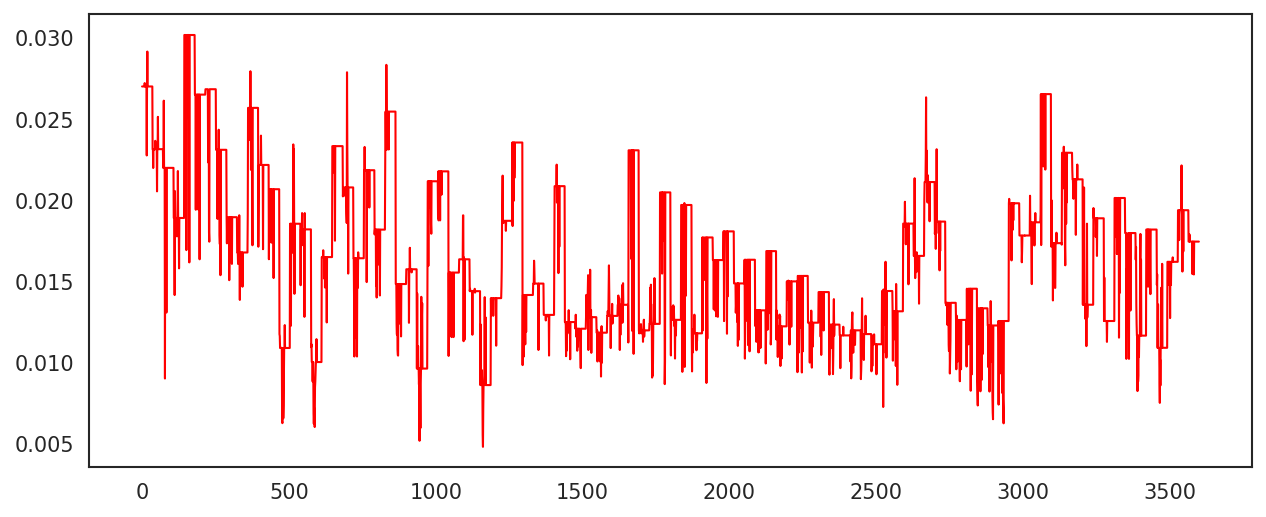

In [199]:
plt.figure(figsize=(10,4), dpi=150)
plt.plot(np.arange(len(Distance_Gomez[0:3600])), Distance_Gomez[0:3600], c='r', lw=1)

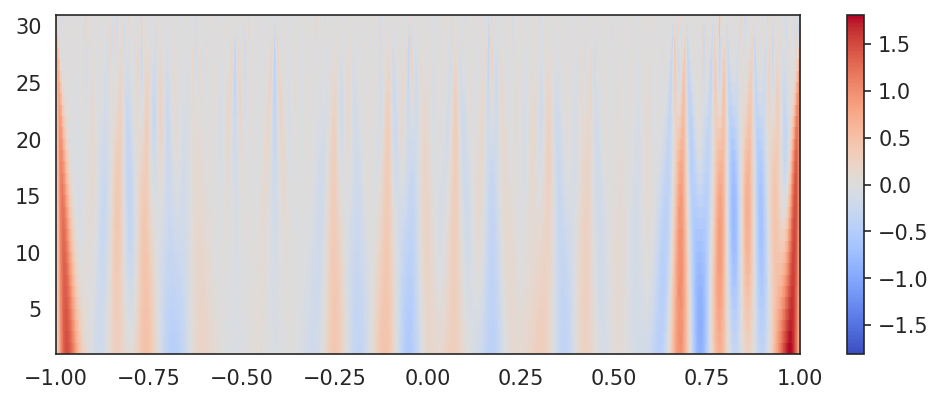

In [71]:
# wavenet
import pywt
widths = np.arange(1, 31)
cwtmatr, freqs = pywt.cwt(Distance_Gomez[:2000], widths, 'mexh')
plt.figure(figsize=(8, 3), dpi=150)
plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='coolwarm', aspect='auto',
            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  
plt.colorbar();

In [137]:
# ex). 10番目のcontoursで考えてみる
# cnt_10 = contours[10]
# print(cnt_10[0][0,0])
# print(cnt_10[0][0,1])
# print(cnt_10[0])

# 重心からのDistanceをだす．
# Distance = []
# for cnts in cnt_10:
#     # cntのx座標とy座標を入れる
#     x_10 = cnts[0,0]
#     y_10 = cnts[0,1]
#     x = cx[10]
#     y = cy[10]
#     dis = sqrt((x_10-x)**2 + (y_10-y)**2)
#     Distance.append(dis)
# plt.plot(np.arange(len(Distance)), Distance)

In [178]:
# デモしてみる
# from math import pi
# from math import sqrt
# from math import atan, cos

# x,y = 2,2
# x1, y1 = 4,4

# ang = 45
# rad = ang*pi/180

# # x1 = dis * cos(rad) + x
# dis = (x1-x)/cos(rad)
# dis

2.82842712474619

In [205]:
len(Shortest)

1677

## DataFrame

In [75]:
import pandas as pd
df = pd.DataFrame({'Areas(px^2)': Areas, 'Circularity': Circularities, 'Equal Diameters(px)': Eq_diameters, 'Shortest Ax(px)': Shortest, 'Longest Ax(px)': Longest, 'Perimeters(px)': Perimeters})

In [76]:
df.head()

,Areas(px^2),Circularity,Equal Diameters(px),Shortest Ax(px),Longest Ax(px),Perimeters(px)
0,514.5,0.801032,25.594565,25.503332,27.112251,89.840619
1,676.5,0.830823,29.348706,28.908627,30.733318,101.154327
2,896.0,0.599426,33.776066,25.249752,50.010708,137.053823
3,1140.0,0.650784,38.098466,28.460991,54.169891,148.367531
4,692.0,0.692205,29.683021,24.897728,40.408512,112.083261


In [245]:
# 外れ値
# df.loc[df['Longest Length(px)'] > 700]
# >>> 1678, 1341

In [159]:
# df.drop(1678,axis=0, inplace=True)
# df.drop(1341,axis=0, inplace=True)

In [77]:
df.describe()

,Areas(px^2),Circularity,Equal Diameters(px),Shortest Ax(px),Longest Ax(px),Perimeters(px)
count,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000,1677.000000
mean,1549.794872,0.740954,43.230081,38.045352,52.276229,158.237737
std,751.961125,0.051207,10.221668,9.052897,13.735454,38.640624
min,435.500000,0.458090,23.547735,17.306765,26.689754,82.526911
25%,980.000000,0.709558,35.323855,31.017382,41.704628,128.124890
50%,1326.000000,0.745033,41.089118,36.168808,49.810143,150.267025
75%,1953.000000,0.776931,49.866189,44.260605,60.823879,184.267026
max,4459.500000,0.870617,75.352583,66.482422,100.780159,280.249781


sample number = 1677



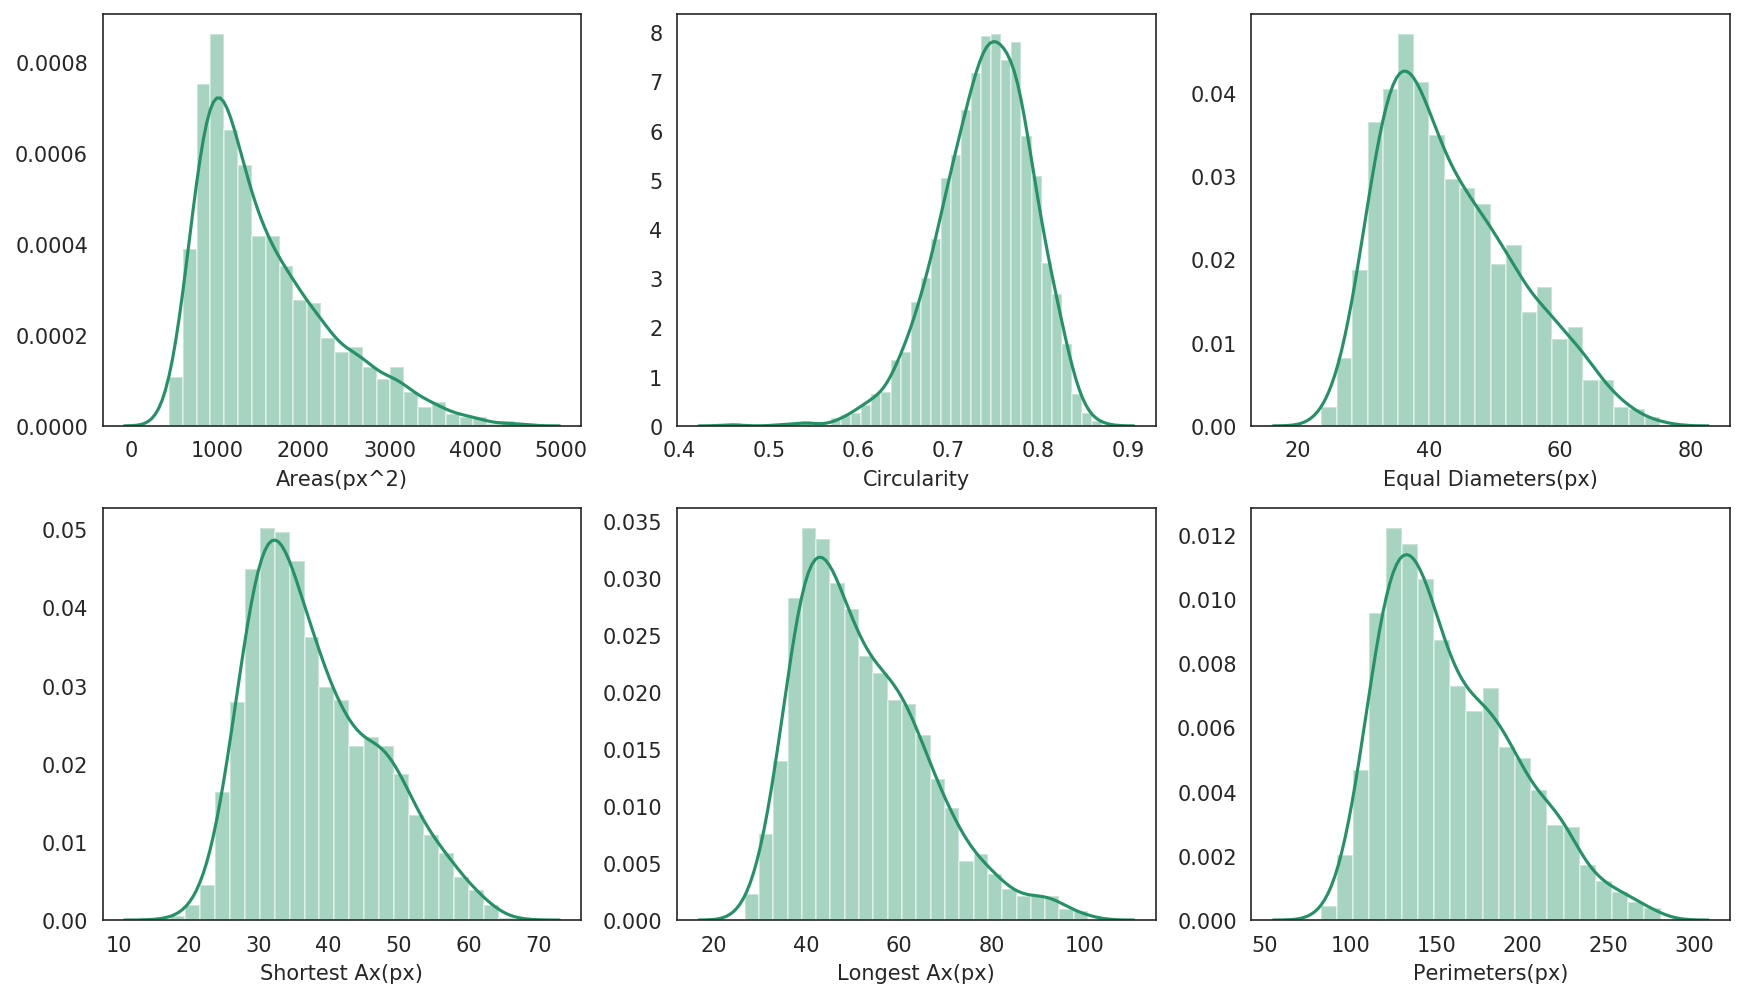

In [79]:
import seaborn as sns
sns.set_style('white')
sns.set_palette('summer')
print('sample number = {}\n'.format(len(contours)))
fig, ax = plt.subplots(2,3,figsize=(14,8), dpi=150)

sns.distplot(df['Areas(px^2)'], ax=ax[0,0])
sns.distplot(df['Circularity'], ax=ax[0,1])
sns.distplot(df['Equal Diameters(px)'], ax=ax[0,2])
sns.distplot(df['Shortest Ax(px)'], ax=ax[1,0])
sns.distplot(df['Longest Ax(px)'], ax=ax[1,1])
sns.distplot(df['Perimeters(px)'], ax=ax[1,2]);

In [109]:
fig.savefig('histgram.png', dpi=100)

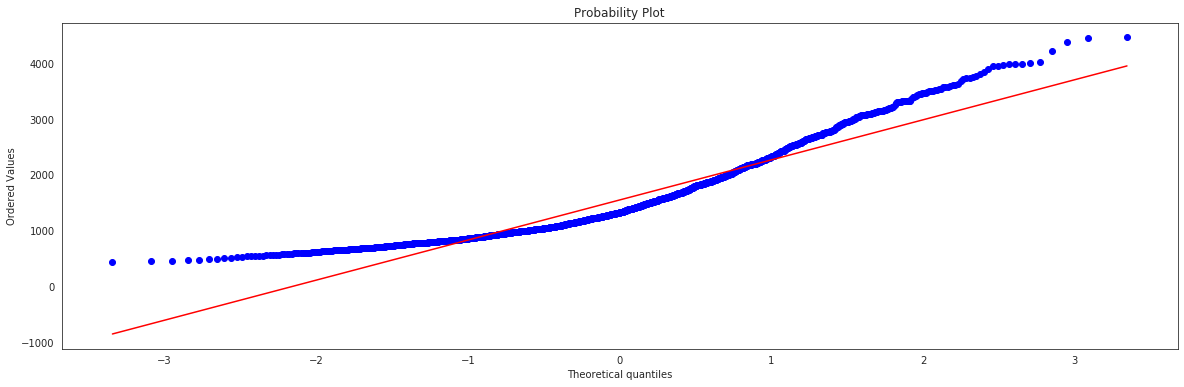

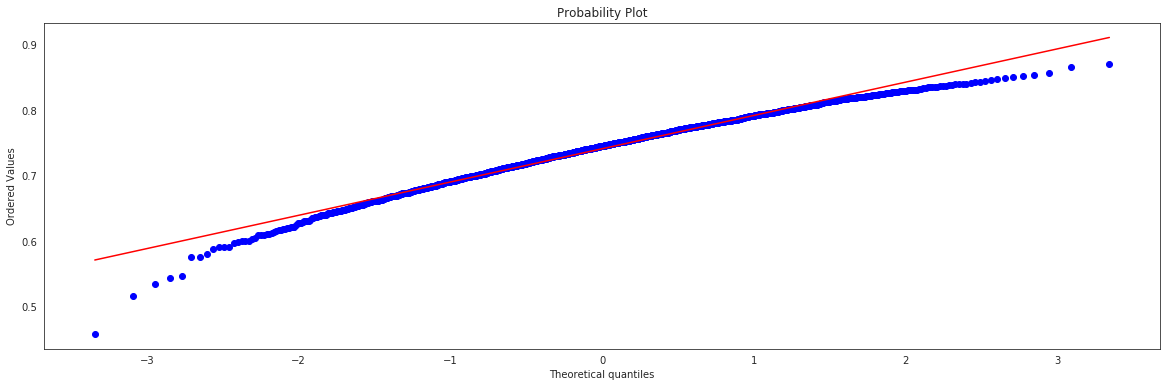

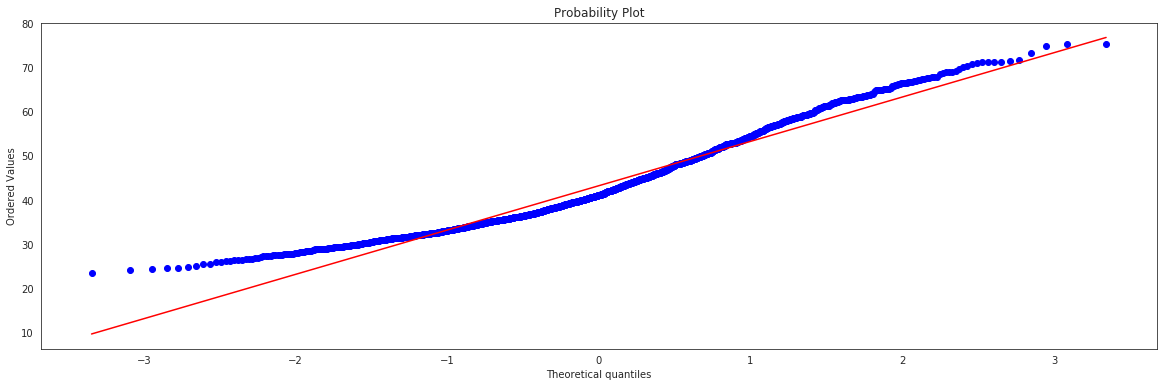

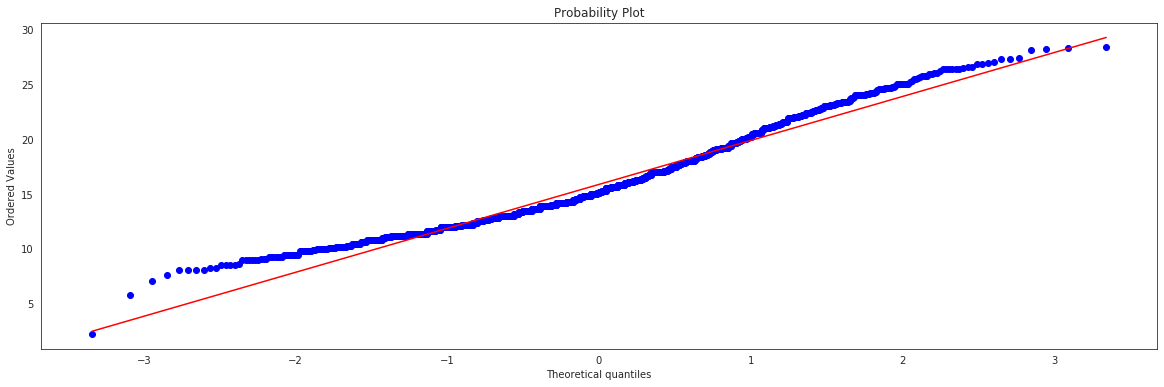

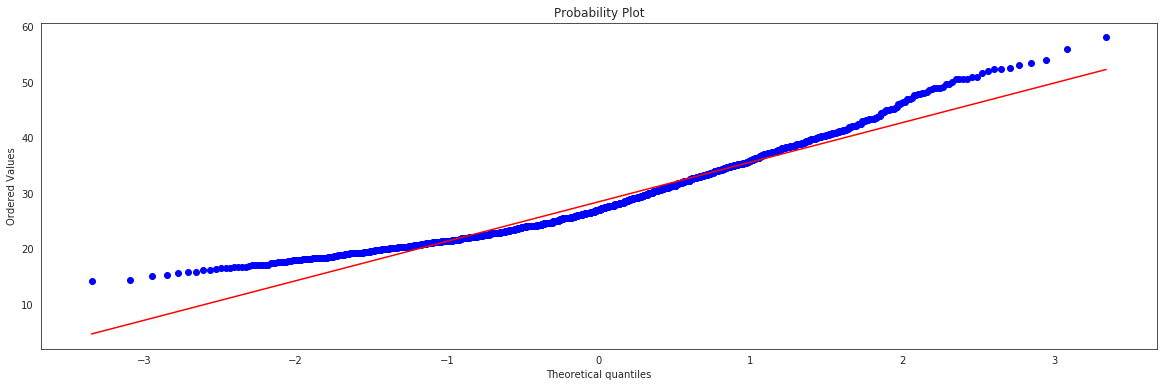

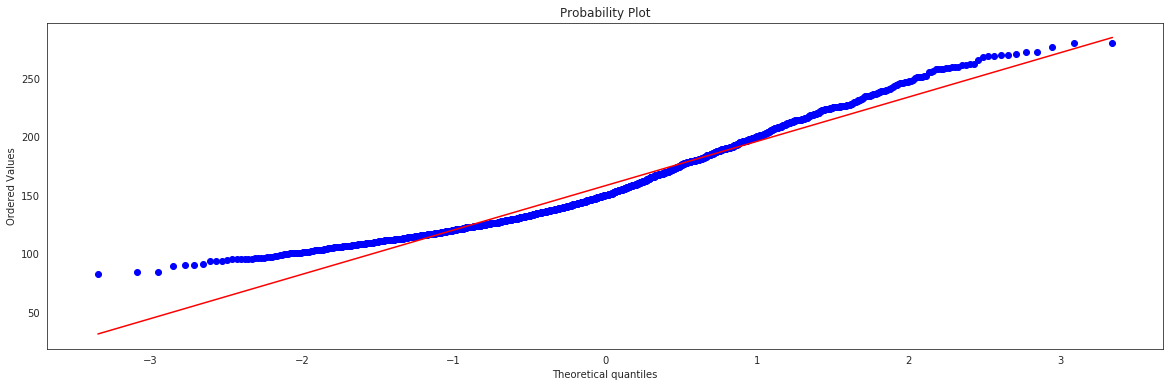

In [64]:
# 確立分布適合度検定 (QQ-plot) - normal
import scipy.stats as stats

plt.figure()
stats.probplot(Areas, dist="norm", plot=plt);

plt.figure()
stats.probplot(Circularities, dist="norm", plot=plt);

plt.figure()
stats.probplot(Eq_diameters, dist="norm", plot=plt);

plt.figure()
stats.probplot(Shortest, dist="norm", plot=plt);

plt.figure()
stats.probplot(Longest, dist="norm", plot=plt);

plt.figure()
stats.probplot(Perimeters, dist="norm", plot=plt);


In [54]:
import warnings
import numpy as np
import pandas as pd
import scipy.stats as st
import statsmodels as sm
import matplotlib


matplotlib.rcParams['figure.figsize'] = (16.0, 12.0)
matplotlib.style.use('ggplot')

# Create models from data
def best_fit_distribution(data, bins=200, ax=None):
    """Model data by finding best fit distribution to data"""
    # Get histogram of original data
    y, x = np.histogram(data, bins=bins, density=True)
    x = (x + np.roll(x, -1))[:-1] / 2.0

    # Distributions to check
    DISTRIBUTIONS = [        
        st.beta,st.gamma,st.lognorm,
        st.norm,st.weibull_min,st.weibull_max
    ]

    # Best holders
    best_distribution = st.norm
    best_params = (0.0, 1.0)
    best_sse = np.inf

    # Estimate distribution parameters from data
    for distribution in DISTRIBUTIONS:

        # Try to fit the distribution
        try:
            # Ignore warnings from data that can't be fit
            with warnings.catch_warnings():
                warnings.filterwarnings('ignore')

                # fit dist to data
                params = distribution.fit(data)

                # Separate parts of parameters
                arg = params[:-2]
                loc = params[-2]
                scale = params[-1]

                # Calculate fitted PDF and error with fit in distribution
                pdf = distribution.pdf(x, loc=loc, scale=scale, *arg)
                sse = np.sum(np.power(y - pdf, 2.0))

                # if axis pass in add to plot
                try:
                    if ax:
                        label = distribution.name
                        pd.Series(pdf, x).plot(ax=ax, label=label, legend=True)
                        ax.legend(loc='upper right')
                    end
                except Exception:
                    pass

                # identify if this distribution is better
                if best_sse > sse > 0:
                    best_distribution = distribution
                    best_params = params
                    best_sse = sse

        except Exception:
            pass

    return (best_distribution.name, best_params)

def make_pdf(dist, params, size=10000):
    """Generate distributions's Probability Distribution Function """

    # Separate parts of parameters
    arg = params[:-2]
    loc = params[-2]
    scale = params[-1]

    # Get sane start and end points of distribution
    start = dist.ppf(0.01, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.01, loc=loc, scale=scale)
    end = dist.ppf(0.99, *arg, loc=loc, scale=scale) if arg else dist.ppf(0.99, loc=loc, scale=scale)

    # Build PDF and turn into pandas Series
    x = np.linspace(start, end, size)
    y = dist.pdf(x, loc=loc, scale=scale, *arg)
    pdf = pd.Series(y, x)

    return pdf

# Probability Density Functionをそれぞれ見つける
data_all = [Areas, Circularities, Eq_diameters, Shortest, Longest, Perimeters]
data_name = ['Areas', 'Circularities', 'Eq_diameters', 'Shortest', 'Longest', 'Perimeters']
for i in range(len(data_all)):
    # Load data from statsmodels datasets
    data = pd.Series(data_all[i])
    
    # Find best fit distribution
    best_fit_name, best_fit_params = best_fit_distribution(data, 200, ax)
    best_dist = getattr(st, best_fit_name)

    # Make PDF with best params 
    pdf = make_pdf(best_dist, best_fit_params)

    param_names = (best_dist.shapes + ', loc, scale').split(', ') if best_dist.shapes else ['loc', 'scale']
    param_str = ', '.join(['{}={:0.2f}'.format(k,v) for k,v in zip(param_names, best_fit_params)])
    dist_str = '{}({})'.format(best_fit_name, param_str)

    print(f'{str(data_name[i])}: {dist_str}')

NameError: name 'ax' is not defined

In [53]:
from functions.pdf import best_fit_distribution, make_pdf, find_PDF

# Probability Density Functionをそれぞれ見つける
data_all = [Areas, Circularities, Eq_diameters, Shortest, Longest, Perimeters]
data_name = ['Areas', 'Circularities', 'Eq_diameters', 'Shortest', 'Longest', 'Perimeters']

find_PDF(data_all, data_name)

NameError: name 'ax' is not defined